# This file contains python code to run a Sr isotope box model; used to create Model 1 (Fig. 6 in manuscript)

## Define functions and parameters

The following blocks of code define modules, parameters, and functions/equations needed for the model

In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

In [2]:
# Functions
# ---------
def simNSr(jr, jh, jcarb):
    """
    Strontium Mass Balance

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    jh : float
        Hydrothermal flux of Sr.
    jcarb : float
        strontium uptake during carbonate deposition
    
    Returns
    -------
    nsr : float
        Seawater Sr reservoir size in mol
    """
    nsr = jr + jh - jcarb
    return nsr

# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0


    jcarb0 = jr[0] + jh[0]
    k = jcarb0 / n[0]
    jcarb = jcarb0
    
    for i in range(nt-1):
        n[i+1] = n[i] + simNSr(jr[i], jh[i], jcarb)*dt
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
        jcarb = k * n[i]
    
   
    return rsw

## Define time and initial values

The following blocks of code create the time array and assign variables their initial values

In [3]:
# Define array of time
tmin = -435    
tmax = -395
nt = 100000     # number of steps
dt = (tmax - tmin)*1e6 / nt    # size of each step
time = np.linspace(0, (tmax - tmin)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and parameters
# -----------------------------
# Riverine flux
Jriv0 = 3.34e10 #(Jones and Jenkyns, 2001)
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio
Rriv0 = 0.7107 # (Peucker-Ehrenbrink and Fiske, 2019); 0.7103-0.7108 
Rriv = np.ones(nt) * Rriv0

# Hydrothermal flux
Jh0 = 1.5e10 #(Jones and Jenkyns, 2001)
Jh = np.ones(nt) * Jh0

# Hydrothermal isotopic ratio 
Rh0 = 0.7033 #(Jones and Jenkyns, 2001)
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater
Rsw = np.zeros(nt)

# Reservoir size 
N = np.ones(nt) * 1.24e17 #(Jones and Jenkyns, 2001)

## Define changing Rriv and Jh

The following blocks of code define how Rriv and Jh will change over the course of the model. All other variables are kept constant at initial values

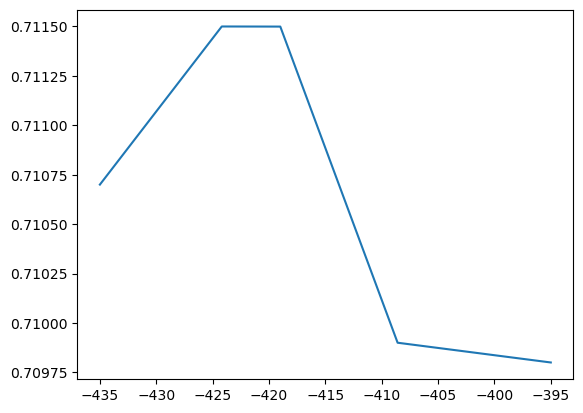

In [5]:
# Define Rriv: best fit to data

# Define time array
timearrayriv = np.linspace(tmin, tmax, nt)

# Define Rriv array
Rriv = np.ones(nt)

# Split Rriv array into intervals as defined by time steps
pt1 = 27000
pt2 = 40000
pt3 = 66000

# Define how Rriv will change within each interval
inc = np.linspace(Rriv0,Rriv0+0.0008,pt1)
Rriv[0:pt1] = inc

Rriv[pt1:pt2] = Rriv[pt1-1]

dec1 = np.linspace(Rriv[pt2-1],Rriv0-0.0008,pt3-pt2)
Rriv[pt2:pt3] = dec1

dec2 = np.linspace(Rriv[pt3-1],Rriv0-0.0009,nt-pt3)
Rriv[pt3:len(Rriv)] = dec2

# Plot
plt.plot(timearrayriv, Rriv)

Text(0, 0.5, 'Sea Level (m above modern)')

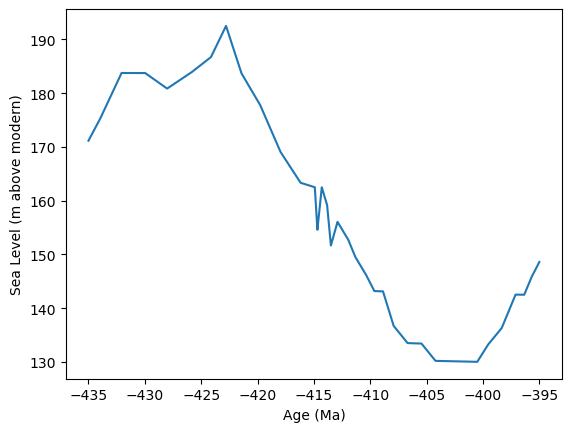

In [6]:
#Define Jh: following Haq and Schutter (2008) sea level curve

# Import Haq and Schutter data
fileHaq = pd.read_excel('../Data/HaqSL.xlsx')
Haqdata = fileHaq[['Age','SL']]

HaqAge = Haqdata.Age.to_numpy()
HaqSL = Haqdata.SL.to_numpy()

#Interpolate
from scipy import interpolate

f = interpolate.interp1d(HaqAge, HaqSL)
sea_level = f(age)

#Plot
plt.plot(age, sea_level)
plt.xlabel('Age (Ma)')
plt.ylabel('Sea Level (m above modern)')

Text(0, 0.5, 'Normalized Sea Level')

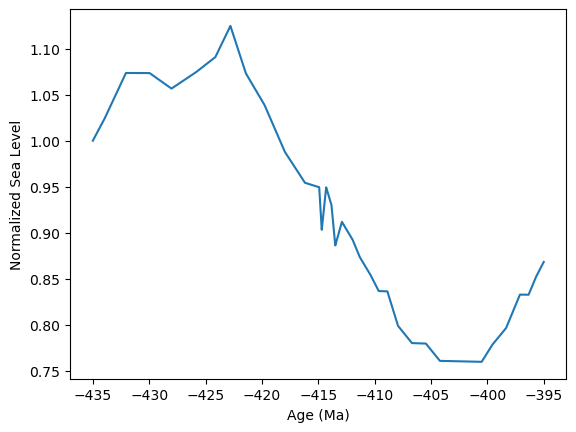

In [7]:
#Define Jh cont.

# normalize sea level relative to mean
sl_norm = sea_level / sea_level.mean()
sl_norm_min = sea_level / sea_level[0]

plt.plot(age, sl_norm_min)
plt.xlabel('Age (Ma)')
plt.ylabel('Normalized Sea Level')

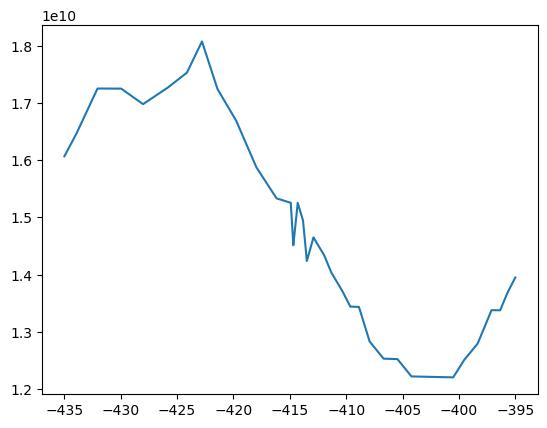

In [8]:
#Define Jh cont.

Jh = sl_norm * Jh0

plt.plot(age, Jh)

## Run Model

In [9]:
Rsw = np.zeros(nt)
Rsw = run_sim(nt, dt, age, Jriv, Rriv, Rsw, Jh, Rh, N)

In [10]:
output_model = {'age':age, 'Rsw':Rsw}

## Plot Model

In [20]:
#Import data

#This study
filePoz = pd.read_excel('../Data/PozaryData.xlsx')
Pozarydata = filePoz[['Age','Sr']]

PozaryAge = Pozarydata.Age.to_numpy()
PozarySr = Pozarydata.Sr.to_numpy()

#Additional studies
fileVan = pd.read_excel('../Data/VanGeldernSr.xlsx')
Vandata = fileVan[['Age','Sr']]

VanAge = Vandata.Age.to_numpy()
VanSr = Vandata.Sr.to_numpy()

fileCramer = pd.read_excel('../Data/CramerSr.xlsx')
Cramerdata = fileCramer[['Age','Sr']]

CramerAge = Cramerdata.Age.to_numpy()
CramerSr = Cramerdata.Sr.to_numpy()

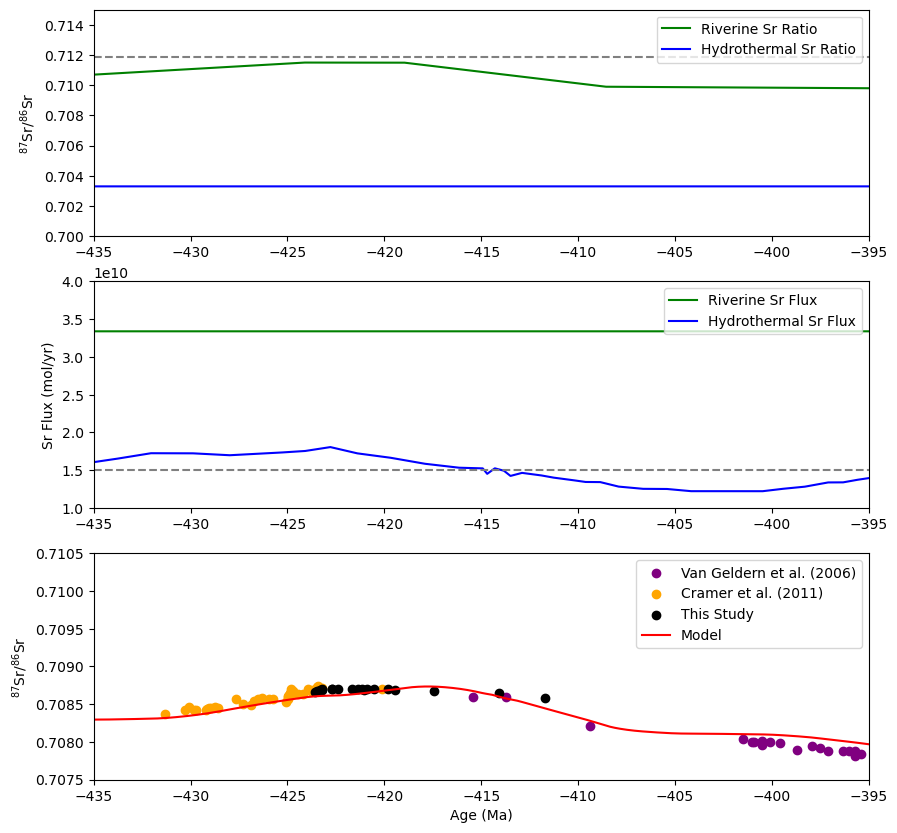

In [22]:
#Plot model

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.plot(age,Rriv, label="Riverine Sr Ratio",color="green")
ax1.plot(age,Rh, label="Hydrothermal Sr Ratio",color="blue")
ax1.set(ylabel='$\mathregular{^{87}Sr/^{86}Sr}$')
ax1.axhline(0.7119,linestyle='dashed', color="gray")
ax1.set_xbound(tmin,tmax)
ax1.set_ybound(0.700,0.715)
ax1.legend(loc='upper right')

ax2.plot(age,Jriv, label="Riverine Sr Flux",color="green")
ax2.plot(age,Jh, label="Hydrothermal Sr Flux",color="blue")
ax2.set(ylabel='Sr Flux (mol/yr)')
ax2.axhline(1.5e10,linestyle='dashed', color="gray")
ax2.set_xbound(tmin,tmax)
ax2.set_ybound(1e10,4e10)
ax2.legend(loc='upper right')

ax3.scatter(VanAge,VanSr, label="Van Geldern et al. (2006)", color="purple")
ax3.scatter(CramerAge,CramerSr, label="Cramer et al. (2011)", color="orange")
ax3.scatter(PozaryAge,PozarySr, label="This Study", color="black")
ax3.plot(output_model['age'],output_model['Rsw'], label="Model", color="red")
ax3.set(ylabel='$\mathregular{^{87}Sr/^{86}Sr}$')
ax3.set(xlabel='Age (Ma)')
ax3.set_xbound(tmin,tmax)
ax3.set_ybound(0.7075,0.7105)
ax3.legend(loc='upper right')